In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filepath = "../data/fires2015_train.csv"

# Read the file into a variable fifa_data
df = pd.read_csv(filepath, parse_dates=True)


df.head(6)

,id,region,district,municipality,parish,lat,lon,origin,alert_date,alert_hour,...,extinction_hour,firstInterv_date,firstInterv_hour,alert_source,village_area,vegetation_area,farming_area,village_veget_area,total_area,cause_type
0,1,Entre Douro e Minho,Viana do Castelo,Ponte de Lima,Serdedelo,41:44:48.5663999999878'',8:31:12.3276000000027'',fire,2015-03-24,17:01:00,...,18:09:00,2015-03-24,17:10:00,NaN,2.5,0.00,0.0,2.50,2.50,negligent
1,2,Entre Douro e Minho,Porto,Marco de Canaveses,Vila Boa de Quires,41:12:58.4280000000109'',8:12:28.3788000000025'',fire,2015-03-24,17:10:00,...,18:47:00,2015-03-24,17:16:00,NaN,0.0,1.35,0.0,1.35,1.35,negligent
2,3,Trás-os-Montes,Vila Real,Boticas,Cerdedo,41:38:07,07:54:43,fire,2015-03-24,21:40:00,...,05:45:00,2015-03-24,22:00:00,NaN,0.5,38.00,0.0,38.50,38.50,negligent
3,4,Trás-os-Montes,Vila Real,Montalegre,Gralhas,41:51:4.15079999998738'',7:42:11.7215999999988'',firepit,2015-03-25,16:00:00,...,17:00:00,2015-03-25,16:14:00,NaN,0.0,0.01,0.0,0.01,0.01,negligent
4,5,Trás-os-Montes,Vila Real,Valpaços,Algeriz,41:35:23,07:24:14,firepit,2015-03-12,17:20:00,...,18:30:00,2015-03-12,17:40:00,NaN,0.1,0.00,0.0,0.10,0.10,rekindling
5,6,Entre Douro e Minho,Vila Real,Mondim de Basto,Ermelo,41:21:02,07:54:57,firepit,2015-03-13,14:48:00,...,16:27:00,2015-03-13,15:18:00,NaN,0.0,0.10,0.0,0.10,0.10,negligent


Structure
1. EDA 
2. data cleaning / preparation (missing values, normalization)
3. model preparation ( target vs explanatory, train-val-set, numnerical + caterical )
4. model selection (we try CATbost & xgbost)
4. feature engeeneering
5. new train 

In [3]:
df.describe()

,id,alert_source,village_area,vegetation_area,farming_area,village_veget_area,total_area
count,7511.000000,0.0,7511.000000,7511.000000,7511.000000,7511.000000,7511.00000
mean,3756.000000,NaN,2.032131,2.855387,0.236093,4.887517,5.12361
std,2168.383269,NaN,30.090253,43.981996,3.515634,62.056953,63.30814
min,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1878.500000,NaN,0.000000,0.000000,0.000000,0.004000,0.01805
50%,3756.000000,NaN,0.000000,0.015000,0.000000,0.053600,0.10000
75%,5633.500000,NaN,0.020000,0.270000,0.000000,0.550000,0.80000
max,7511.000000,NaN,1548.920000,2543.560000,165.000000,3023.990000,3023.99000


In [4]:
# understand each feature
for x in df.columns:
    print(x)

id
region
district
municipality
parish
lat
lon
origin
alert_date
alert_hour
extinction_date
extinction_hour
firstInterv_date
firstInterv_hour
alert_source
village_area
vegetation_area
farming_area
village_veget_area
total_area
cause_type


here I can describe the attributes

In [5]:
# dropping unnecessary columns
unnecessary_col = ['alert_source']
df.drop(unnecessary_col,axis=1,inplace=True)

# making a copy of the dataframe to use in the machine learning model
data = df.copy()

cause_type
intentional    2161
natural         105
negligent      4171
rekindling     1074
Name: id, dtype: int64

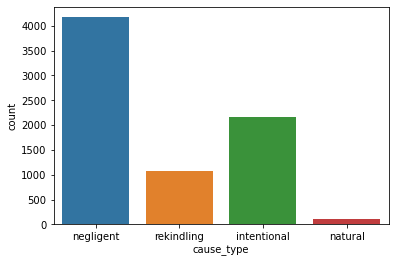

In [6]:
#df['cause_type'].unique()
sns.countplot(x='cause_type', data=df)

s1 = df.groupby(['cause_type']).id.count()
s1

We see that the most frequent reason of fires is the negligence

In [7]:
df['cause_type'].value_counts().index

Index(['negligent', 'intentional', 'rekindling', 'natural'], dtype='object')

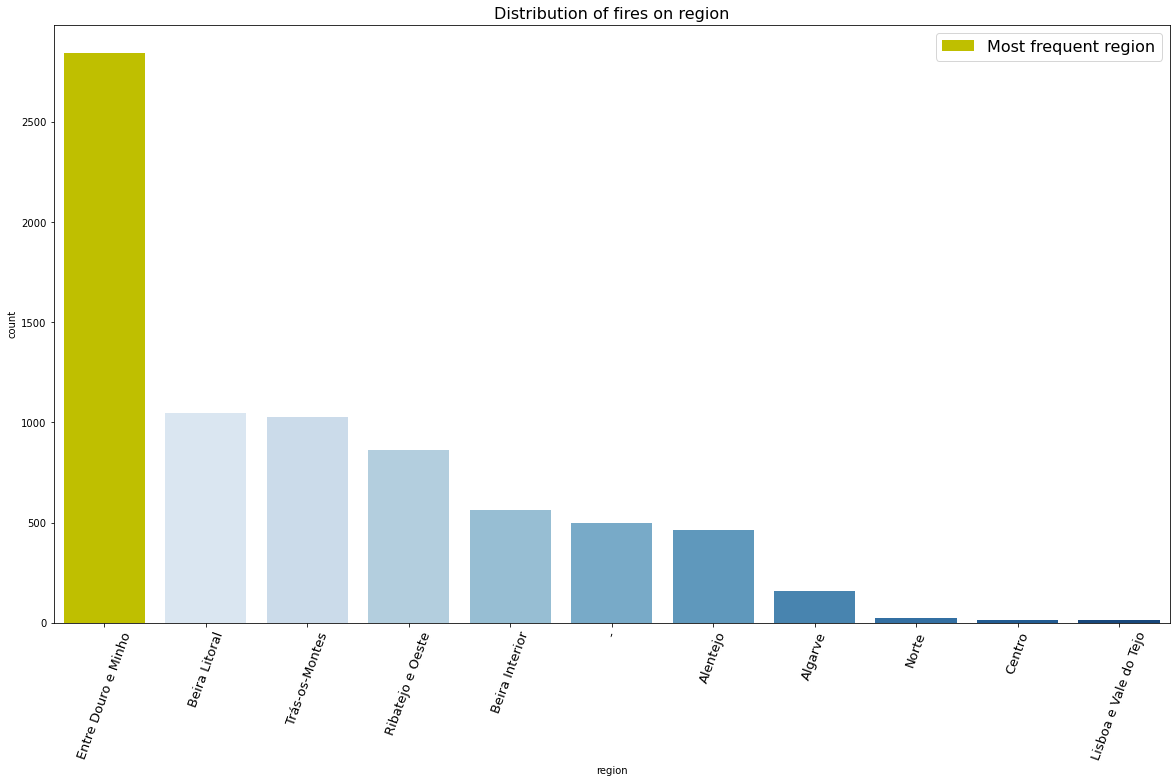

In [8]:
# I want to see what are the regions
plt.figure(figsize=(20,11))
ax = sns.countplot(data=df, x='region',order = df['region'].value_counts().index,palette='Blues',label='Most frequent region')
ax.set_xticklabels(ax.get_xticklabels(),rotation=70,size=13)
ax.set_title('Distribution of fires on region',fontsize=16)
ax.patches[0].set_fc('y')
plt.legend(prop={'size':'16'})

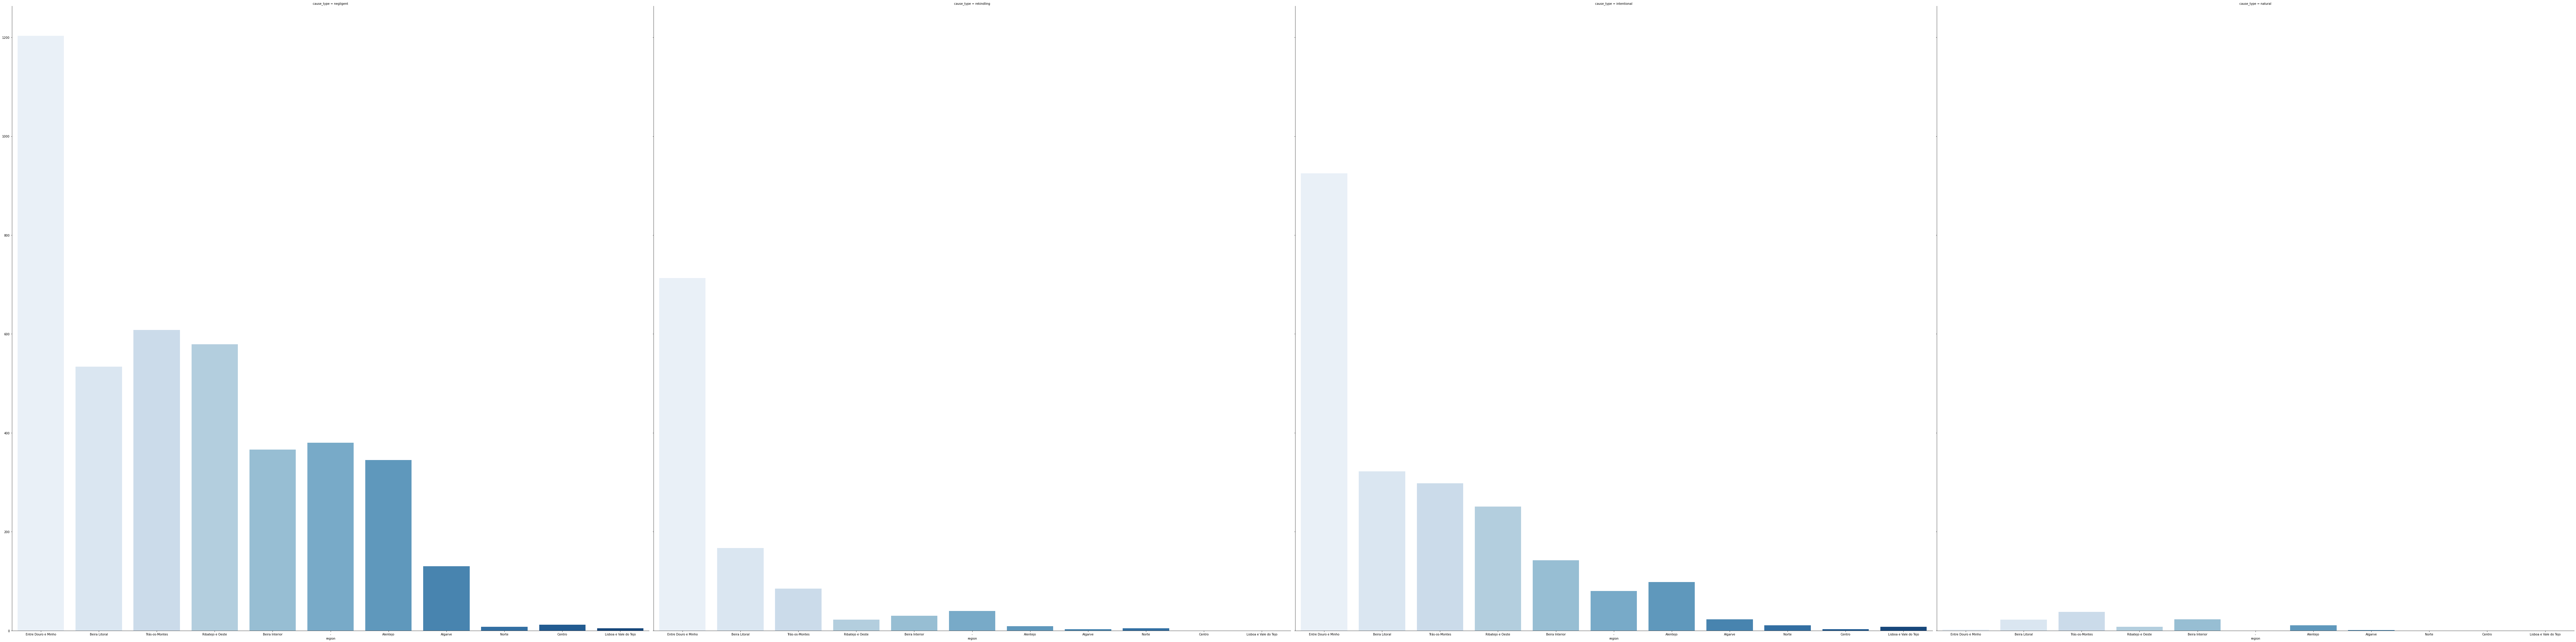

In [9]:
g = sns.FacetGrid(df, col='cause_type', height=30, aspect=1)
g.map(sns.countplot, "region", order=df['region'].value_counts().index,palette='Blues',label='Most frequent region')



The region doesn't seems very indicative for identyfing the cause

In [10]:
def q_first(x):
    return x.quantile(0.25)

def q_third(x):
    return x.quantile(0.75)

def iqr(x):
    return q_third(x)-q_first(x)

df.groupby(['cause_type']).agg({'total_area':['min','max','mean','count','median',q_first,q_third,iqr]})

total_area                                                   \
                   min      max      mean count median q_first  q_third   
cause_type                                                                
intentional     0.0000  3023.99  6.836356  2161   0.15  0.0250  1.00000   
natural         0.0001   570.00  6.771358   105   0.10  0.0100  0.84000   
negligent       0.0000  2557.30  4.441445  4171   0.10  0.0146  0.81325   
rekindling      0.0000  1105.00  4.165558  1074   0.06  0.0100  0.30000   

                      
                 iqr  
cause_type            
intentional  0.97500  
natural      0.83000  
negligent    0.79865  
rekindling   0.29000

/Users/tommasorea/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of target variable (total_area)')

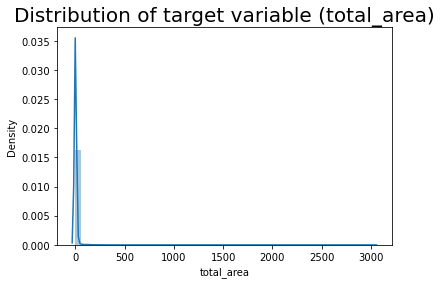

In [11]:
# Understanding the distribution of the target variable
ax = sns.distplot(df.total_area)
ax.set_title('Distribution of target variable (total_area)',fontsize=20)

In [12]:
df.columns

Index(['id', 'region', 'district', 'municipality', 'parish', 'lat', 'lon',
       'origin', 'alert_date', 'alert_hour', 'extinction_date',
       'extinction_hour', 'firstInterv_date', 'firstInterv_hour',
       'village_area', 'vegetation_area', 'farming_area', 'village_veget_area',
       'total_area', 'cause_type'],
      dtype='object')

In [13]:
df.head()

,id,region,district,municipality,parish,lat,lon,origin,alert_date,alert_hour,extinction_date,extinction_hour,firstInterv_date,firstInterv_hour,village_area,vegetation_area,farming_area,village_veget_area,total_area,cause_type
0,1,Entre Douro e Minho,Viana do Castelo,Ponte de Lima,Serdedelo,41:44:48.5663999999878'',8:31:12.3276000000027'',fire,2015-03-24,17:01:00,2015-03-24,18:09:00,2015-03-24,17:10:00,2.5,0.00,0.0,2.50,2.50,negligent
1,2,Entre Douro e Minho,Porto,Marco de Canaveses,Vila Boa de Quires,41:12:58.4280000000109'',8:12:28.3788000000025'',fire,2015-03-24,17:10:00,2015-03-24,18:47:00,2015-03-24,17:16:00,0.0,1.35,0.0,1.35,1.35,negligent
2,3,Trás-os-Montes,Vila Real,Boticas,Cerdedo,41:38:07,07:54:43,fire,2015-03-24,21:40:00,2015-03-25,05:45:00,2015-03-24,22:00:00,0.5,38.00,0.0,38.50,38.50,negligent
3,4,Trás-os-Montes,Vila Real,Montalegre,Gralhas,41:51:4.15079999998738'',7:42:11.7215999999988'',firepit,2015-03-25,16:00:00,2015-03-25,17:00:00,2015-03-25,16:14:00,0.0,0.01,0.0,0.01,0.01,negligent
4,5,Trás-os-Montes,Vila Real,Valpaços,Algeriz,41:35:23,07:24:14,firepit,2015-03-12,17:20:00,2015-03-12,18:30:00,2015-03-12,17:40:00,0.1,0.00,0.0,0.10,0.10,rekindling


In [14]:
df['alert_datetime'] = pd.to_datetime(df['alert_date']+ ' ' + df['alert_hour'])
df['extinction_datetime'] = pd.to_datetime(df['extinction_date'] + ' ' + df['extinction_hour'])
df['firstInterv_datetime'] = pd.to_datetime(df['firstInterv_date']+ ' ' + df['firstInterv_hour'])


In [15]:
# date_diff minutes
df['alert_to_interv'] = df.apply(lambda row : (pd.Timedelta(row['firstInterv_datetime'] - row['alert_datetime']).seconds / 60.0), axis = 1)
df['interv_to_extinction'] = df.apply(lambda row : (pd.Timedelta(row['extinction_datetime'] - row['firstInterv_datetime']).seconds / 60.0), axis = 1)



In [16]:
df[['alert_to_interv','interv_to_extinction']].head()

,alert_to_interv,interv_to_extinction
0,9.0,59.0
1,6.0,91.0
2,20.0,465.0
3,14.0,46.0
4,20.0,50.0


In [17]:
df.head()

,id,region,district,municipality,parish,lat,lon,origin,alert_date,alert_hour,...,vegetation_area,farming_area,village_veget_area,total_area,cause_type,alert_datetime,extinction_datetime,firstInterv_datetime,alert_to_interv,interv_to_extinction
0,1,Entre Douro e Minho,Viana do Castelo,Ponte de Lima,Serdedelo,41:44:48.5663999999878'',8:31:12.3276000000027'',fire,2015-03-24,17:01:00,...,0.00,0.0,2.50,2.50,negligent,2015-03-24 17:01:00,2015-03-24 18:09:00,2015-03-24 17:10:00,9.0,59.0
1,2,Entre Douro e Minho,Porto,Marco de Canaveses,Vila Boa de Quires,41:12:58.4280000000109'',8:12:28.3788000000025'',fire,2015-03-24,17:10:00,...,1.35,0.0,1.35,1.35,negligent,2015-03-24 17:10:00,2015-03-24 18:47:00,2015-03-24 17:16:00,6.0,91.0
2,3,Trás-os-Montes,Vila Real,Boticas,Cerdedo,41:38:07,07:54:43,fire,2015-03-24,21:40:00,...,38.00,0.0,38.50,38.50,negligent,2015-03-24 21:40:00,2015-03-25 05:45:00,2015-03-24 22:00:00,20.0,465.0
3,4,Trás-os-Montes,Vila Real,Montalegre,Gralhas,41:51:4.15079999998738'',7:42:11.7215999999988'',firepit,2015-03-25,16:00:00,...,0.01,0.0,0.01,0.01,negligent,2015-03-25 16:00:00,2015-03-25 17:00:00,2015-03-25 16:14:00,14.0,46.0
4,5,Trás-os-Montes,Vila Real,Valpaços,Algeriz,41:35:23,07:24:14,firepit,2015-03-12,17:20:00,...,0.00,0.0,0.10,0.10,rekindling,2015-03-12 17:20:00,2015-03-12 18:30:00,2015-03-12 17:40:00,20.0,50.0


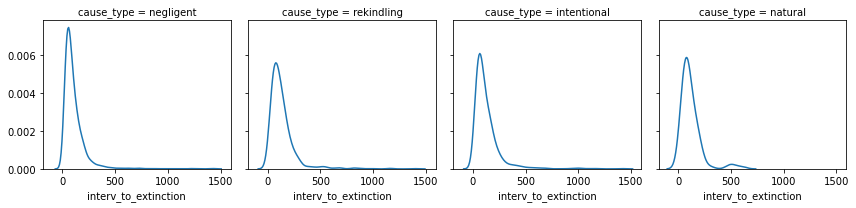

In [25]:
g = sns.FacetGrid(df, col="cause_type", margin_titles=True, despine=False)
g.map_dataframe(sns.kdeplot, "interv_to_extinction")

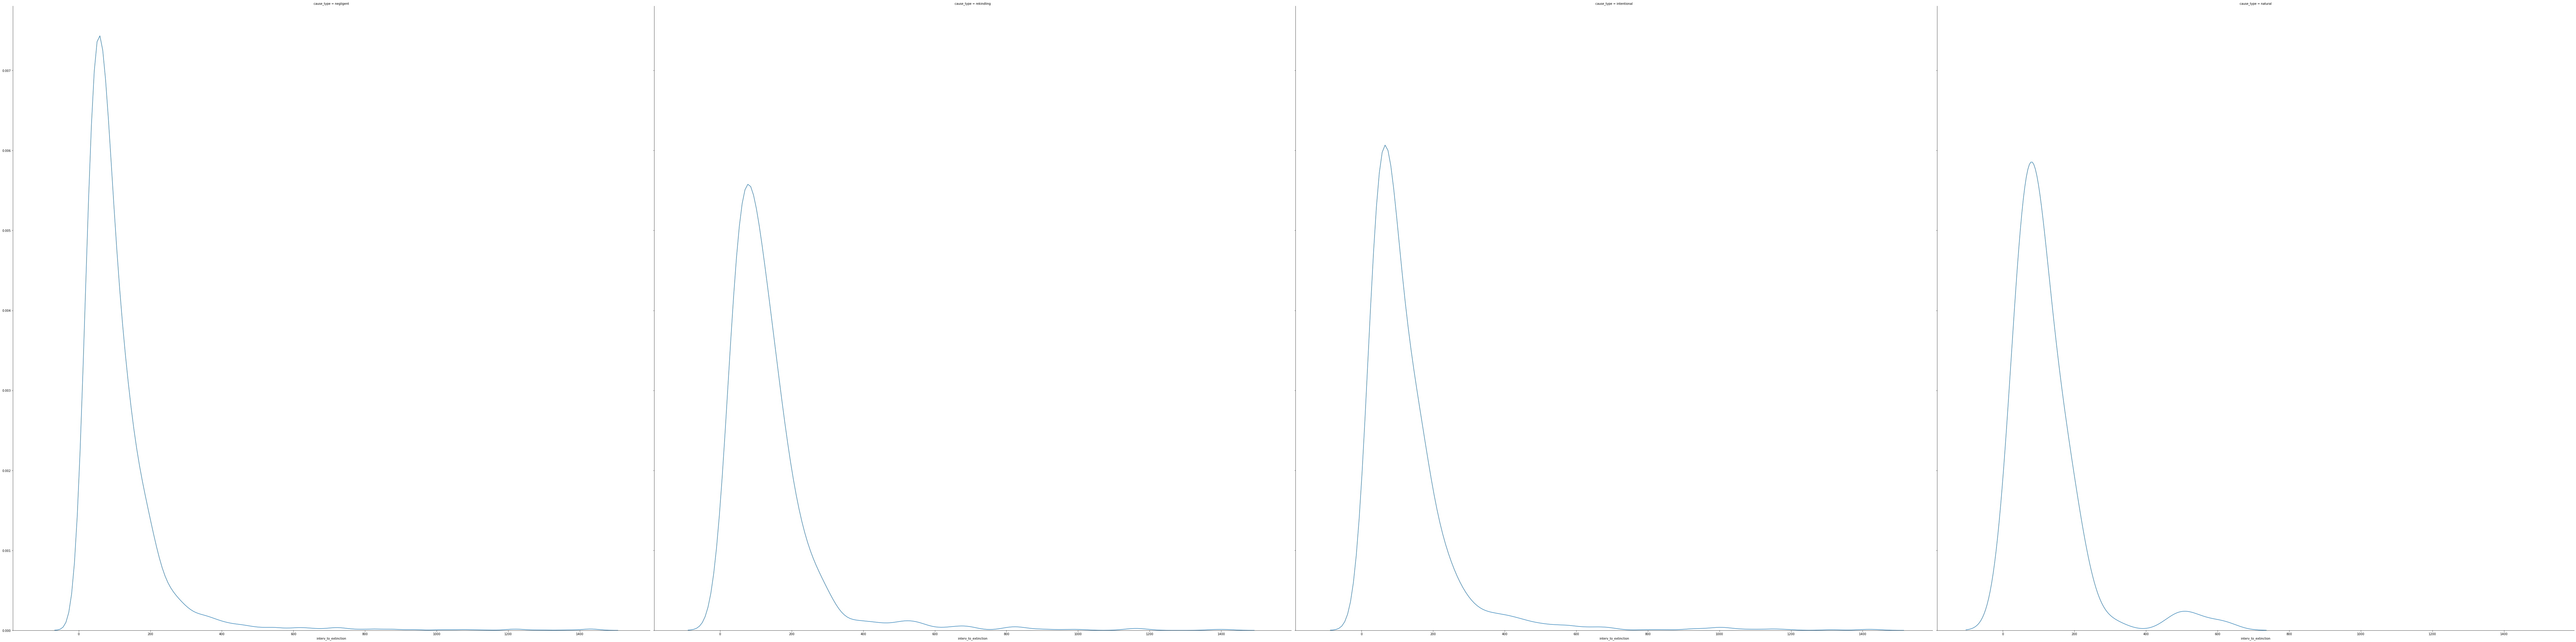

In [23]:
#sns.kdeplot(data=df,x="interv_to_extinction")
g = sns.FacetGrid(df, col='cause_type', height=30, aspect=1)
g.map(sns.kdeplot, "interv_to_extinction",label='Most frequent region')


<AxesSubplot:xlabel='total_bill', ylabel='Density'>

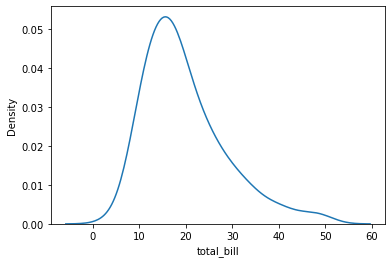

In [20]:

sns.kdeplot(data=tips,x="total_bill")

In [213]:
sns.__version__

'0.9.0'

In [209]:
python --version

NameError: name 'python' is not defined